In [23]:
import sys
import os
from IPython.display import Image
os.getcwd()
sys.path.append('C:\\Users\\Anna Lara\\Documents\\05_GIT\\Snowmodel\\model')

In [3]:
#sys.path

In [4]:
import numpy as np
from model import *


In [30]:
help Image

SyntaxError: invalid syntax (<ipython-input-30-1660ddb58785>, line 1)

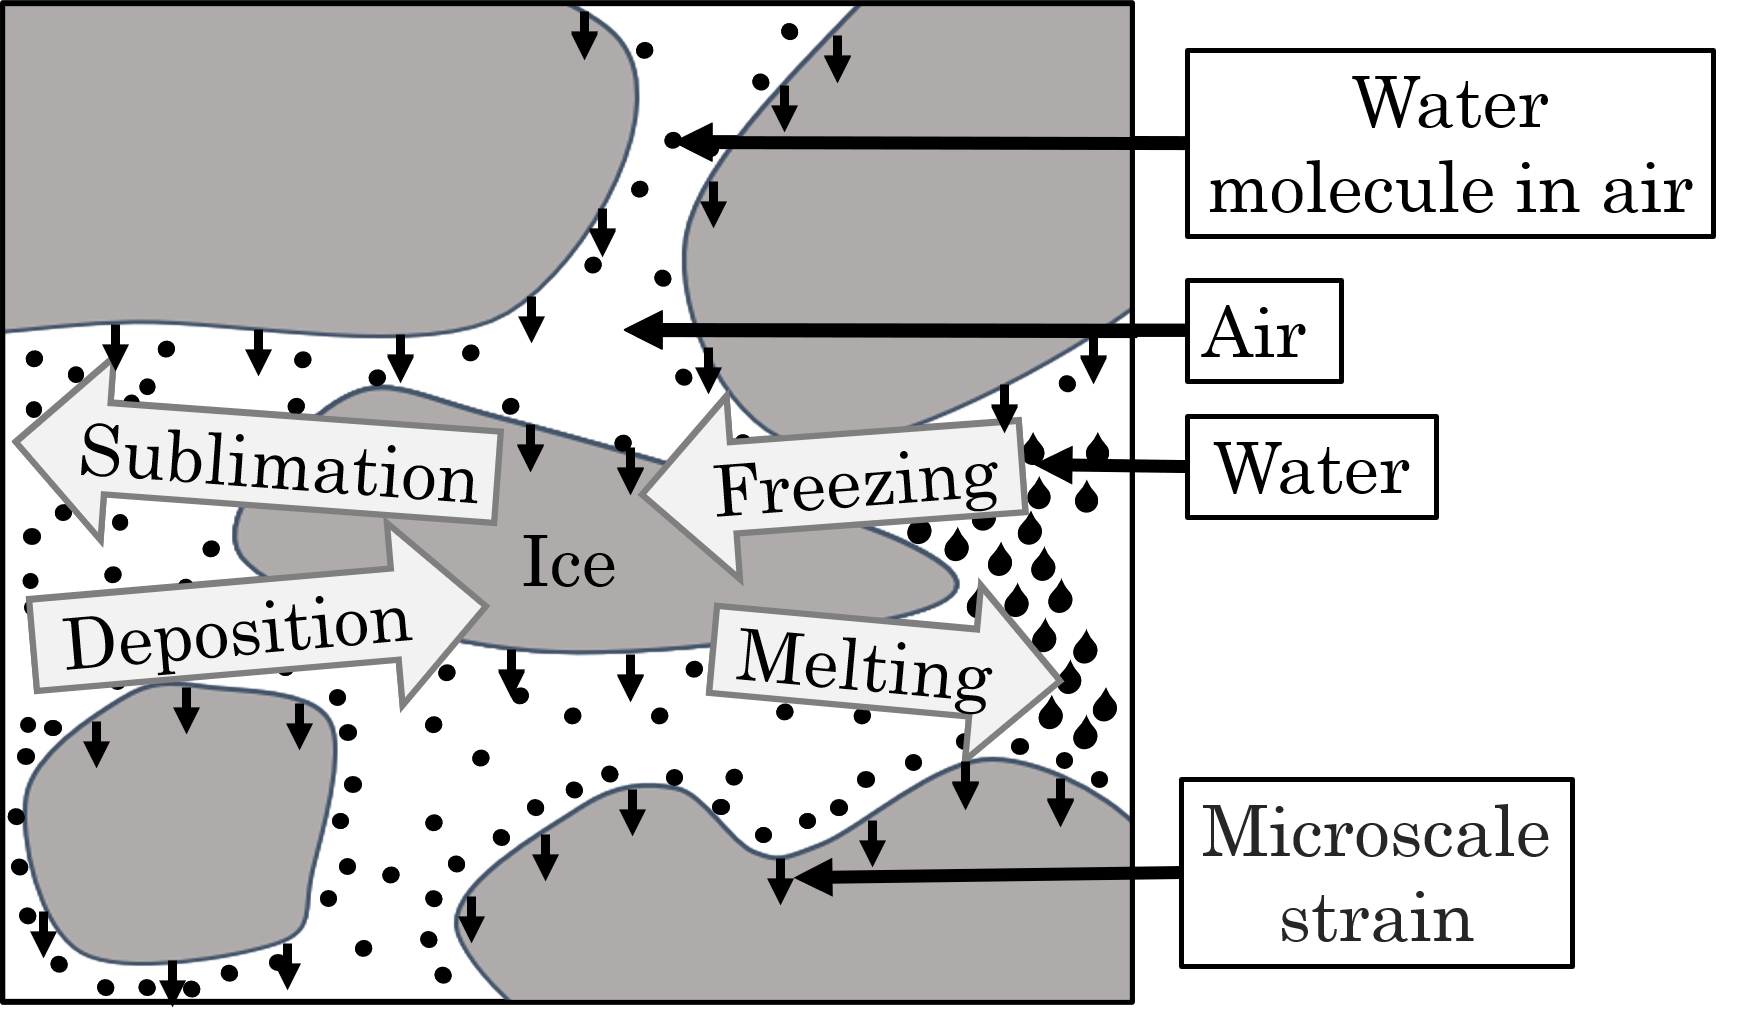

In [36]:
i = Image(filename='Bilder/Fig1.png', width = 500, height = 200)
i

#### Initialize model geometry
In set_up_model_geometry you can choose several intial geometries via *geom* that are described in the docstring. 'FieldScale0.5m' is a snowpack of an initial height *Z* of 0.5 m, 101 computational nodes *nz*, which means a node distance *dz* of 0.005 m. *coord* contains the exact z-coordinates of all computational nodes.


In [5]:
geom = 'FieldScale0.5m'
[nz, dz, Z, coord] = set_up_model_geometry(geom)

#### Initialize time step and maximum iteration number
*it* is the maximum number of iterations. The first time step *dt* is set to 0.01 s and the time passed *t_passed* is 0 s. *iter_max* is the maximum iteration numer. 

In [6]:
it = 7000
[iter_max, dt, t_passed] = set_up_iter(it)  

#### Set initial conditions for temperature and snow density
set_initial_conditions defines the initial conditions for temperature *T* and snow density *rho_eff*. *RHO_ini* and *T_ini* can be replace by all options listed in the doc string of *set_initial_conditions*. *RHO_2Layer_Continuous_smooth* reflects a snowpack with two equally thick snow layers of which the lower one is denser (150 kgm$^{-3}$) and the upper one is lighter (75 kgm$^{-3}$). Ice volume fraction *phi* is then derived from snow density *rho_eff* with *retrieve_phi_from_rho_eff*

In [7]:
T_ini = 'T_const_263'
RHO_ini =  'RHO_2Layer_Continuous_smooth'
[T, rho_eff] = set_initial_conditions(nz, Z, RHO_ini, T_ini)
phi = retrieve_phi_from_rho_eff (nz, rho_eff)

#### Set up matrices to store results for each time step

In [8]:
[all_D_eff, all_k_eff, all_FN, all_rhoC_eff, all_rho_v, all_T,all_c, all_phi, all_rho_eff,all_coord, \
 all_v, all_sigma, all_t_passed, all_dz] = set_up_matrices(iter_max, nz)


#### Initialize mesh fourier number *FN* and deposition rate *c*

In [9]:
FN = np.zeros(nz)
c = np.zeros(nz)

#### Initialize model parameters
Diffusion coefficient *D_eff*, thermal conductivity *k_eff*, heat capacity *rhoC_eff*, *rho_v* saturation water vapor density and *rho_v_dT* is temperature derivate of the saturation water vapor density the. SWVD stands for saturation water vapor density and is an option to decide on the equation to be used for the computation. We choose 'Libbrecht'.

In [10]:
SWVD = 'Libbrecht'
[D_eff, k_eff, rhoC_eff, rho_v, rho_v_dT] =\
update_model_parameters(phi, T, nz, coord, SWVD)

#### Initialize settling velocity
*v* is the settling velocity *v_dz* is the z derivative of the velocity and sigma is the vertical stress at each grid node. *SetVel* can be set to 'Y' and 'N' to include or exclude settling respectively. *v_opt* is the option for velocity computation that are described in the docstring. We choose *continuous*. *viscosity* is an option for the viscosity computation. We choose *eta_constant_n1*.

\begin{equation}\label{eq:vvsstrainrate}
    \nabla v = \dot{\epsilon},
\end{equation}

\begin{equation}
    \dot{\epsilon}  = \frac{1}{\eta} \sigma^m,
\end{equation}

\begin{equation}
    \partial_z v = \frac{1}{\eta} \left( g \int_z^{H(t)} \phi_i\left(\zeta \right) \rho_i \, d \zeta \right)^{m}.
\end{equation}

\begin{equation}\label{equ:velocity}
v (z) = - \int_0^z \frac{1}{\eta} \left( g \int_{\tilde z}^{H(t)} \phi_i(\zeta)\rho_i d \zeta \right)^{m} \, d\tilde{z},
\end{equation}

In [11]:
SetVel = 'Y'
v_opt = 'continuous'
viscosity = 'eta_constant_n1'
[v, v_dz, sigma] =\
settling_vel(T, nz, coord, phi, SetVel, v_opt, viscosity)

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

Ice mass balance: 
\begin{equation}
    \partial_t \phi_i + \nabla \cdot (\mathbf{v}\,\phi_i) = \frac{c}{\rho_i},
    \label{equ:icemassbalance}
\end{equation}

Water vapor transport:
\begin{equation} \label{eq:vapormassbalance}
    \partial_t \left( \rho_v \, (1- \phi_i) \right) - \nabla \cdot \left( D_{eff} \, \nabla \rho_v \right) + \rho_v \, \nabla \cdot \left(v \,\phi_i \right) = -c,
\end{equation}

<IPython.core.display.Javascript object>


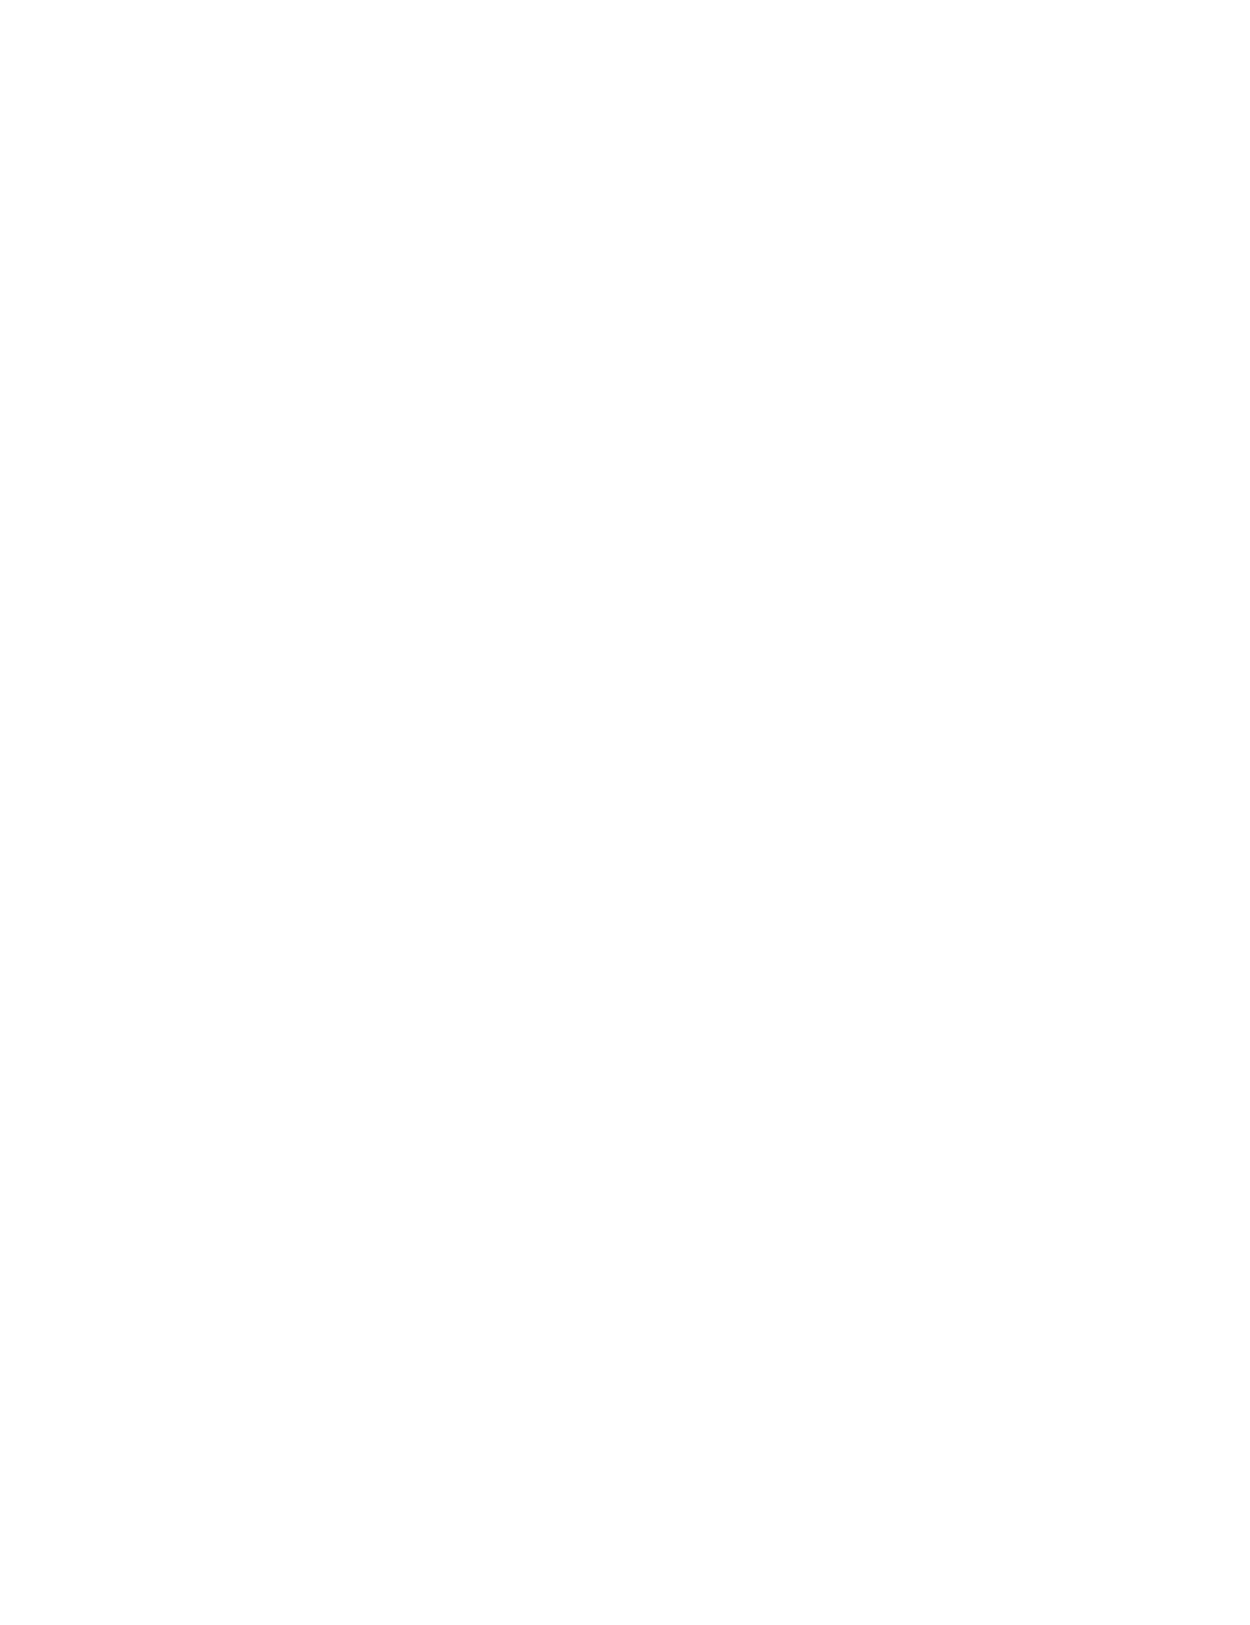

KeyboardInterrupt: 

In [19]:
%matplotlib notebook
fig,(ax1, ax2, ax3, ax4,ax5) = plt.subplots(5,1, figsize=(10,13))
for t in range(iter_max):
    # if t_passed > 3600*(24*2) : # e.g. 2 days
    #     to_stop = 5
    #print(t)
    if t%50  == 0:
        visualize_juypter(fig, ax1, ax2, ax3, ax4,ax5, T, c, phi, rho_v, v, t)
    [all_D_eff, all_k_eff, all_FN, all_rhoC_eff, all_rho_v, all_T,all_c,all_phi,  all_rho_eff, all_coord, all_v, all_sigma, all_t_passed,  all_dz] \
        =  store_results(all_D_eff, all_k_eff, all_FN, all_rhoC_eff, all_rho_v, all_T, all_c,all_phi, all_rho_eff, all_coord, all_v, all_sigma, all_t_passed,all_dz, D_eff, k_eff, FN, phi, rhoC_eff, rho_v, T, c, rho_eff, coord, v, sigma,  t, iter_max, nz,dz,t_passed)        
    T_prev = T
    # Module I solves for temperature - Diffusion
    (T, a, b) = solve_for_T(T, rho_v,rho_v_dT, k_eff, D_eff, rhoC_eff, phi, v, nz, dt, dz)     
    # Module II solves for deposition rate - Diffusion
    c = solve_for_c(T, T_prev, phi, k_eff, rhoC_eff, D_eff, rho_v, rho_v_dT, v, v_dz, nz, dt, dz)        
    # Module III solves for ice volume fraction and coordinate update - Advection
    (phi, coord, dz, v_dz, v, sigma) = coupled_update_phi_coord(T, c, dt, nz, phi, v_dz, coord, SetVel, v_opt, viscosity)   
    [D_eff, k_eff, rhoC_eff, rho_v, rho_v_dT] = update_model_parameters(phi, T, nz, coord, SWVD)
    t_passed = t_total(t_passed, dt)
    #print(t_passed)
    ## find iteration number for specific time by placing a breakpoint at line 58:

    # activate next line if Module I and II are deactivated
    #dt = 100
    # deactivate next line if Module I and/or II are deactivated
    [dt, FN] = comp_dt(t_passed, dz, a, b)  

In [13]:
def visualize_juypter(fig, ax1, ax2, ax3, ax4,ax5, T, c, phi, rho_v, v, t):
    ax1.plot(phi, coord, label='phi profile at t = ' + str(t))
    ax1.set_xlabel('Liquid fraction [-]')
    ax1.set_ylabel('Height [m]' )
    ax2.plot(T, coord, label='T profile at t = ' + str(t))
    ax2.set_xlabel('Temperature [K]')
    ax2.set_ylabel('Height [m]' )
    ax3.plot(c, coord, label='c at t = ' + str(t))
    ax3.set_xlabel('Deposition rate')
    ax3.set_ylabel('Height [m]' )
    ax4.plot(rho_v, coord, label ='rho_v t = ' + str(t))
    ax4.set_xlabel('Water vapor density')
    ax4.set_ylabel('Height [m]' )
    ax5.plot(v, coord, label='v profile at t = ' + str(t))
    ax5.set_xlabel('Vertical velocity [m/s]')
    ax5.set_ylabel('Height [m]' )

    fig.canvas.draw() 